# Loading useful libraries

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix

# Data cleaning

In [2]:
df = pd.read_csv('../data/prescriber-info.csv')

In [3]:
# Clean State
rare_abbrev = df.groupby('State').size().where(lambda x: x < 10).dropna().index.tolist()
df['State'] = df['State'].apply(lambda x: 'other' if x in rare_abbrev else x)

In [4]:
# Group Credentials into 6 large categories
df['Credentials'] = df['Credentials'].apply(lambda x: str(x).replace('(', '').replace(')', '').replace('.', '').replace(' ', ''))
new_credentials = pd.Series('Other', index=df.index)
new_credentials.loc[df['Credentials'].apply(lambda x: 'MD' in x)] = 'MD'
new_credentials.loc[df['Credentials'].apply(lambda x: 'DDS' in x)] = 'DDS'
new_credentials.loc[df['Credentials'].apply(lambda x: 'DO' in x)] = 'DO'
new_credentials.loc[df['Credentials'].apply(lambda x: 'NP' in x or 'APRN' in x or 'NURSEPRACTITIONER' in x)] = 'NP'
new_credentials.loc[df['Credentials'].apply(lambda x: 'PA' in x or 'PHYSICIANASSIST' in x)] = 'PA'
df['Credentials'] = new_credentials

In [5]:
# Get common specialties as specialties with more than 50 practitioners
common_specialties = df.groupby('Specialty').size().where(lambda x: x > 50).dropna().index.tolist()

new_specialties = pd.Series('other', index=df.index)
new_specialties[df['Specialty'].apply(lambda x: x in common_specialties)] = df['Specialty']
new_specialties[df['Specialty'].apply(lambda x: 'surg' in x.lower())] = 'Surgeon'
new_specialties[df['Specialty'].apply(lambda x: 'pain' in x.lower())] = 'Pain Management'
df['Specialty'] = new_specialties

In [6]:
# Remove all information about opiate prescriptions
opioids = pd.read_csv('../data/opioids.csv')
opioids = opioids[opioids.columns[0]].apply(lambda x: x.replace(' ', '.').replace('-', '.')).tolist()
df.drop(columns=set(opioids)&set(df.columns), inplace=True)

In [7]:
# Convert categorical variables using OHE
df = pd.get_dummies(df, prefix='', prefix_sep='',
                    columns=['Gender', 'State', 'Credentials', 'Specialty'], drop_first=True)

In [8]:
# Remove drugs that aren't prescribed in any of the rows (since it's a subset of a larger data set)
df.drop(columns=df.sum(axis=0).where(lambda x: x == 0).dropna().tolist(), inplace=True)

# Remove NPI
df.drop(columns='NPI', inplace=True)

# Model building

In [9]:
X = df.drop(columns='Opioid.Prescriber')
y = df['Opioid.Prescriber']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

In [10]:
parameters = {'n_estimators': range(50, 500, 50), 'max_depth': range(1, 9, 2)}
gbt = GradientBoostingClassifier(learning_rate=0.1, random_state=42)
clf = GridSearchCV(gbt, parameters)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': range(1, 9, 2), 'n_estimators': range(50, 500, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [11]:
print('Gradient tree boosting classifier accuracy score: {:.2%}'.format(clf.score(X_test, y_test)))

Gradient tree boosting classifier accuracy score: 84.82%


# Confusion matrix

Confusion matrix, without normalization
[[1745  330]
 [ 429 2496]]
Normalized confusion matrix
[[0.84096386 0.15903614]
 [0.14666667 0.85333333]]


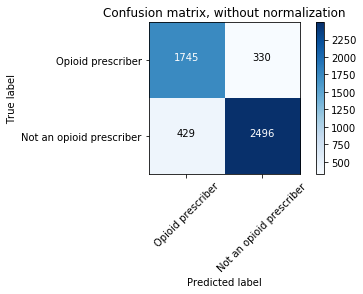

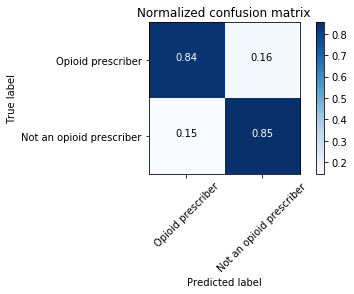

In [12]:
y_pred = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
class_names = ['Opioid prescriber', 'Not an opioid prescriber']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Feature importance

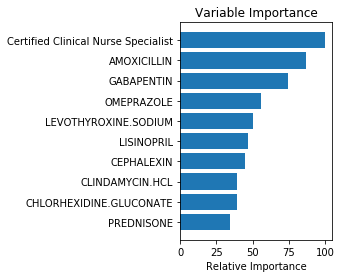

In [14]:
feature_importance = clf.best_estimator_.feature_importances_

# Make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-10:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()